<a href="https://colab.research.google.com/drive/10cpkWNGmttP5hOkqPjKybL628FTcBeD0?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Построение вопросно-ответной системы с использованием RAG

План проведения экспериментов:

1. Использовать готовую модель Word2Vec, преобразовать колонку с контекстами в вектора, провести брутфорсом поиск для каждого вопроса в БД (использовать косинусную близость и эвклидово расстояние), посчитать качество.


2. Обучить свою модель Word2Vec, преобразовать колонку с контекстами в вектора, провести брутфорсом поиск для каждого вопроса в БД (использовать косинусную близость и эвклидово расстояние), посчитать качество.

3. Обогатить датасет, увеличить до 100 000 строк и замерить время извлечения ответа на маленьком (12 000) и большом (100 000) датасете.

4. Поместить полученные с помощью word2vec векторы (маленький датасет 12000) в БД Qdrant.

5. Замерить качество.

6. Замерить время извлечения ответа и сравнить с пунктом 3.

7. Увеличить кол-во векторов в БД, замерить время.

### импорты

In [1]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import re
import random
import time

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import precision_score


import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt_tab')

tokenizer = WordPunctTokenizer()

import gensim
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# фиксируем seed
random.seed(42)
np.random.seed(42)

### загрузка датасета

In [3]:
# загрузка csv файла из google drive
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dgnwG1AZhspMJaDR6jz828qZkSnZg25t' -O full_dataset.csv

--2024-12-07 12:46:21--  https://docs.google.com/uc?export=download&id=1dgnwG1AZhspMJaDR6jz828qZkSnZg25t
Resolving docs.google.com (docs.google.com)... 74.125.128.102, 74.125.128.138, 74.125.128.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.128.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1dgnwG1AZhspMJaDR6jz828qZkSnZg25t&export=download [following]
--2024-12-07 12:46:22--  https://drive.usercontent.google.com/download?id=1dgnwG1AZhspMJaDR6jz828qZkSnZg25t&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.31.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45451452 (43M) [application/octet-stream]
Saving to: ‘full_dataset.csv’

full_dataset.csv    100%[===================>]  43.35M   107MB/s   

In [4]:
rag_dataset = pd.read_csv('full_dataset.csv')
rag_dataset

,context,question,answer
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...
1,RWSN Collaborations\nSouthern Africa Self-supp...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...
2,All Android applications categories\nDescripti...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...
3,"How unequal is India? The question is simple, ...",What is the main difference between the Nation...,The main difference between the NSS and the IH...
4,Gunnar Nelson took his time on the feet agains...,How did Gunnar Nelson win the fight against Za...,Gunnar Nelson won the fight against Zak Cummin...
...,...,...,...
11995,"Fuzzy's Ultra Premium Vodka\nThe Myth, The Man...",What are some of the achievements of Fuzzy Zoe...,Fuzzy Zoeller is known for his golfing success...
11996,Swedish Grand Prix rider Malin Nilsson got mar...,Who did Malin Nilsson marry on 2 June 2018?,"Malin Nilsson got married to her partner, Germ..."
11997,The Cracchiolo Law Library of the James E. Rog...,What is the Fellowship in Law Librarianship of...,The Fellowship in Law Librarianship is a progr...
11998,2nd physical eMAG store opens in Mammut\nOnlin...,Where has the second physical eMAG store been ...,The second physical eMAG store has been opened...


In [5]:
# вывод одного сэмпла
rag_dataset.values[0]

array(['Caption: Tasmanian berry grower Nic Hansen showing Macau chef Antimo Merone around his property as part of export engagement activities.\nTHE RISE and rise of the Australian strawberry, raspberry and blackberry industries has seen the sectors redouble their international trade focus, with the release of a dedicated export plan to grow their global presence over the next 10 years.\nDriven by significant grower input, the Berry Export Summary 2028 maps the sectors’ current position, where they want to be, high-opportunity markets and next steps.\nHort Innovation trade manager Jenny Van de Meeberg said the value and volume of raspberry and blackberry exports rose by 100 per cent between 2016 and 2017. She said the Australian strawberry industry experienced similar success with an almost 30 per cent rise in export volume and a 26 per cent rise in value to $32.6M over the same period.\n“Australian berry sectors are in a firm position at the moment,” she said. “Production, adoption o

Видны посторонние символы, такие как перевод строки \n

Имеется 3 колонки и 12000 строк

In [6]:
rag_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   12000 non-null  object
 1   question  11997 non-null  object
 2   answer    11997 non-null  object
dtypes: object(3)
memory usage: 281.4+ KB


In [7]:
df = rag_dataset.copy()

df.columns

Index(['context', 'question', 'answer'], dtype='object')

In [8]:
# удаление строк с пустыми значениями (None)
df = df.dropna()

In [9]:
# приведем к нижнему регистру тексты во всех колонках
df['context'] = df['context'].apply(lambda x: x.lower())
df['question'] = df['question'].apply(lambda x: x.lower())
df['answer'] = df['answer'].apply(lambda x: x.lower())

df

,context,question,answer
0,caption: tasmanian berry grower nic hansen sho...,what is the berry export summary 2028 and what...,the berry export summary 2028 is a dedicated e...
1,rwsn collaborations\nsouthern africa self-supp...,what are some of the benefits reported from ha...,benefits reported from having access to self-s...
2,all android applications categories\ndescripti...,what are the unique features of the coolands f...,the unique features of the coolands for twitte...
3,"how unequal is india? the question is simple, ...",what is the main difference between the nation...,the main difference between the nss and the ih...
4,gunnar nelson took his time on the feet agains...,how did gunnar nelson win the fight against za...,gunnar nelson won the fight against zak cummin...
...,...,...,...
11995,"fuzzy's ultra premium vodka\nthe myth, the man...",what are some of the achievements of fuzzy zoe...,fuzzy zoeller is known for his golfing success...
11996,swedish grand prix rider malin nilsson got mar...,who did malin nilsson marry on 2 june 2018?,"malin nilsson got married to her partner, germ..."
11997,the cracchiolo law library of the james e. rog...,what is the fellowship in law librarianship of...,the fellowship in law librarianship is a progr...
11998,2nd physical emag store opens in mammut\nonlin...,where has the second physical emag store been ...,the second physical emag store has been opened...


In [10]:
# удаление/замена на пробел знака перевода строки в колонке 'context'
df['context'] = df['context'].apply(lambda x: x.replace('\n', ' '))

In [11]:
# проверка на полные дубликаты
df[df.duplicated()]

,context,question,answer


In [12]:
# проверка на дубликаты в колонке context
df[df.duplicated(subset=['context'])]

,context,question,answer


In [13]:
# проверка на дубликаты в колонке answer
df[df.duplicated(subset=['answer'])]

,context,question,answer


In [14]:
# проверка на дубликаты в колонке question
df[df.duplicated(subset=['question'], keep=False)].sort_values('question')

,context,question,answer
9991,background – nectar mattress review – is this ...,what are some of the features that set the nec...,some of the features that set the nectar mattr...
6225,background – nectar mattress review – is this ...,what are some of the features that set the nec...,the nectar mattress is a reasonably priced foa...
9259,explore concrete pump operator careers and fin...,what are some of the job roles mentioned in th...,some of the job roles mentioned in the context...
9070,lead teacher jobs teacher - early childhoodnew...,what are some of the job roles mentioned in th...,some of the job roles mentioned in the context...
11587,"i'm sorry the pictures are so dark.....""someon...",what are the ingredients needed for the recipe...,the ingredients needed for the recipe are .5 c...
2599,description if i eat flour i prefer to eat rye...,what are the ingredients needed for the recipe...,the ingredients needed for the recipe are rye ...
10753,hose hook up for jet skichameleon dating sites...,what is the context about?,"the context is about various topics, including..."
8322,"""they are both comparatively late age, on n'a ...",what is the context about?,the context is a collection of various sentenc...
11483,order by popularity | order by alphabet like s...,what is the context about?,the context is about a list of titles or phras...
6217,the synthetic fragrant compounds based on 2-te...,what is the context about?,the context is about synthetic fragrant compou...


In [15]:
# удаление найденных дубликатов по 'question'
df.duplicated(subset=['question'], keep=False)
df.drop_duplicates(subset = ['question'], keep = 'first', inplace = True)


In [16]:
# в ходе экспериментов ниже с векторами были обнаружены две строки с другим языком
df.drop(index=[7453, 10225], inplace=True)
df.reset_index(drop=True, inplace=True) # обновление индексов

## Word2Vec

#### Функции

1. Функция для извлечения эмбеддинга из фразы/контекста - делаем усреднение (принимает фразу и модель, отдает вектор)
2. Функция для вычисления косинусной близости и эвклидова расстояния контекстов и вопросов по датасету (принимает датафрейм, метод близости, модель и число топ, возвращает индекс наиболее близкого ответа).
3. Функция, осуществляющая поиск брутфорсом (принимает вопрос, ищет по базе ответ)

In [17]:
# функция для формирования эмбеддинга из фразы через среднее

def get_phrase_embedding(phrase, model):
    """
    конвертация фразы в вектор через усреднение
    """
    vector = np.zeros([model.vector_size], dtype='float32')
    phrase_tokenized = tokenizer.tokenize(phrase.lower())
    phrase_vectors = [model[x] for x in phrase_tokenized if model.has_index_for(x)]

    if len(phrase_vectors) != 0:
        vector = np.mean(phrase_vectors, axis=0)
    return vector

In [18]:
# Функция для вычисления близости по паре вопрос-ответ
def similarity(df, method, model):
    if method == 'cos':
        cos_sim = []
        for index, row in tqdm(df.iterrows()):
            sim = cosine_similarity(get_phrase_embedding(row['context'], model).reshape(1, -1), get_phrase_embedding(row['question'], model).reshape(1, -1))
            cos_sim.append(sim[0][0])
        return cos_sim
    if method == 'euc':
        euc_sim = []
        for index, row in tqdm(df.iterrows()):
            euc = euclidean_distances(get_phrase_embedding(row['context'], model).reshape(1, -1), get_phrase_embedding(row['question'], model).reshape(1, -1))
            euc_sim.append(euc[0][0])
        return euc_sim

In [19]:
# поиск осуществляет поиск и преобразует вопрос в вектор
def search(query, df, sim_method, model, top_k=3):
    query_vec = get_phrase_embedding(query, model)
    if sim_method == 'cos':
        similarities = cosine_similarity([query_vec], list(df['context_vec']))
        top_indices = similarities[0].argsort()[-top_k:][::-1]
        return df.iloc[top_indices][['context_vec']]
    if sim_method == 'euc':
        similarities = euclidean_distances([query_vec], list(df['context_vec']))
        top_indices = similarities[0].argsort()[:top_k]
        return df.iloc[top_indices][['context_vec']]

In [20]:
# поиск осуществляет только поиск
def search_(query_vec, df, sim_method, model, top_k=3):
    if sim_method == 'cos':
        similarities = cosine_similarity([query_vec], list(df['context_vec']))
        top_indices = similarities[0].argsort()[-top_k:][::-1]
        return df.iloc[top_indices][['context_vec']]
    if sim_method == 'euc':
        similarities = euclidean_distances([query_vec], list(df['context_vec']))
        top_indices = similarities[0].argsort()[:top_k]
        return df.iloc[top_indices][['context_vec']]

### готовая модель glove-twitter-100

Попробуем готовую модель 'glove-twitter-100' для получения эмбеддингов

In [ ]:
# пробуем готовую модель 'glove-twitter-100' для получения эмбеддингов
# загрузка модели
import gensim.downloader as api
model_glove_100 = api.load('glove-twitter-100')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [ ]:
# вектор слова и длина вектора
model_glove_100.get_vector('success'), model_glove_100.vector_size

(array([-0.69571 , -0.25803 ,  1.1461  , -0.092474,  0.013327,  0.88868 ,
         0.6629  , -0.22854 , -0.61239 ,  0.023411,  0.13384 , -1.2871  ,
        -3.9963  ,  0.05135 , -0.16849 ,  0.2833  ,  0.23867 , -0.29322 ,
        -0.47725 ,  0.27753 ,  0.6445  ,  0.13722 , -0.05108 ,  0.16066 ,
         0.07651 ,  1.1067  ,  0.045127,  0.44216 ,  0.50982 ,  0.21219 ,
        -0.65819 ,  0.070122, -0.048726,  0.29361 ,  1.1018  ,  0.56088 ,
         0.53527 ,  0.071109, -0.76369 , -0.27487 ,  0.58741 ,  0.46964 ,
        -0.097834, -0.070362,  0.7466  , -0.23906 , -0.3333  , -0.44176 ,
         0.28084 ,  0.36565 ,  0.49095 , -0.1077  , -0.66796 , -0.29881 ,
         0.20242 ,  0.10429 ,  0.29653 , -0.24588 , -0.87941 , -0.41375 ,
        -0.046369, -0.373   ,  0.17329 ,  0.19251 ,  0.89135 , -0.11747 ,
         0.42172 , -0.75693 , -0.35015 , -0.12428 ,  0.33944 , -0.096263,
        -0.43658 ,  0.92614 ,  0.2422  , -0.35407 ,  0.38964 , -0.69092 ,
        -0.16011 , -0.43882 ,  0.24384

In [ ]:
# проверка модели
model_glove_100.most_similar(positive=['success'], topn=5)

[('failure', 0.7855759263038635),
 ('achieve', 0.7644059658050537),
 ('progress', 0.7620401978492737),
 ('successful', 0.7617712616920471),
 ('happiness', 0.757005512714386)]

#### cos_sim/euc_dist

In [ ]:
df_glove = df.copy()

In [ ]:
# Добавляем столбец с эмбеддингами контекста в датасет:
df_glove['context_vec'] = df_glove['context'].apply(lambda x: get_phrase_embedding(x, model_glove_100))
df_glove

,context,question,answer,context_vec
0,caption: tasmanian berry grower nic hansen sho...,what is the berry export summary 2028 and what...,the berry export summary 2028 is a dedicated e...,"[0.09504911, -0.049641673, 0.089875646, 0.0277..."
1,rwsn collaborations southern africa self-suppl...,what are some of the benefits reported from ha...,benefits reported from having access to self-s...,"[0.1335789, -0.047594383, 0.0615254, 0.1200428..."
2,all android applications categories descriptio...,what are the unique features of the coolands f...,the unique features of the coolands for twitte...,"[0.17623802, 0.13942787, -0.0018227642, 0.1532..."
3,"how unequal is india? the question is simple, ...",what is the main difference between the nation...,the main difference between the nss and the ih...,"[0.15724678, -0.051185735, 0.12862964, 0.12895..."
4,gunnar nelson took his time on the feet agains...,how did gunnar nelson win the fight against za...,gunnar nelson won the fight against zak cummin...,"[0.17708059, 0.06809667, 0.18565966, 0.0115498..."
...,...,...,...,...
11976,"fuzzy's ultra premium vodka the myth, the man,...",what are some of the achievements of fuzzy zoe...,fuzzy zoeller is known for his golfing success...,"[0.06778479, -0.05240954, 0.07101283, 0.143693..."
11977,swedish grand prix rider malin nilsson got mar...,who did malin nilsson marry on 2 june 2018?,"malin nilsson got married to her partner, germ...","[0.06751342, -0.014983839, 0.10461176, 0.05301..."
11978,the cracchiolo law library of the james e. rog...,what is the fellowship in law librarianship of...,the fellowship in law librarianship is a progr...,"[0.11425761, 0.004999416, 0.13181105, 0.180119..."
11979,2nd physical emag store opens in mammut online...,where has the second physical emag store been ...,the second physical emag store has been opened...,"[0.15222545, 0.008151223, 0.051334146, 0.08177..."


In [ ]:
query = df.question[10]

In [ ]:
# тест поиска ответа для query по датасету df_glove по косинусному сходству
%time
results = search(query, df_glove, 'cos', model_glove_100, top_k=1)
print(results)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.9 µs
                                           context_vec
110  [0.12597324, 0.12697911, 0.079099506, 0.094262...


In [ ]:
# тест поиска ответа для query по датасету df_glove по эвклидову расстоянию

%time
results = search(query, df_glove, 'euc',  model_glove_100, top_k=1)
print(results)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
                                         context_vec
3  [0.15724678, -0.051185735, 0.12862964, 0.12895...


In [ ]:
# вычисляем близость каждогго вопроса со своим контекстом
cos_sim = similarity(df_glove, 'cos', model_glove_100)
euc_dist = similarity(df_glove, 'euc', model_glove_100)

11981it [00:56, 213.16it/s]
11981it [00:45, 262.89it/s]


In [ ]:
# Добавляем близость и расстояние в датасет
df_glove['cos_similarity_100'] = cos_sim
df_glove['euc_dict_100'] = euc_dist
df_glove

,context,question,answer,context_vec,cos_similarity_100,euc_dict_100
0,caption: tasmanian berry grower nic hansen sho...,what is the berry export summary 2028 and what...,the berry export summary 2028 is a dedicated e...,"[0.09504911, -0.049641673, 0.089875646, 0.0277...",0.955721,1.647024
1,rwsn collaborations southern africa self-suppl...,what are some of the benefits reported from ha...,benefits reported from having access to self-s...,"[0.1335789, -0.047594383, 0.0615254, 0.1200428...",0.982423,1.118146
2,all android applications categories descriptio...,what are the unique features of the coolands f...,the unique features of the coolands for twitte...,"[0.17623802, 0.13942787, -0.0018227642, 0.1532...",0.963876,1.541047
3,"how unequal is india? the question is simple, ...",what is the main difference between the nation...,the main difference between the nss and the ih...,"[0.15724678, -0.051185735, 0.12862964, 0.12895...",0.954969,1.278227
4,gunnar nelson took his time on the feet agains...,how did gunnar nelson win the fight against za...,gunnar nelson won the fight against zak cummin...,"[0.17708059, 0.06809667, 0.18565966, 0.0115498...",0.937649,1.508161
...,...,...,...,...,...,...
11976,"fuzzy's ultra premium vodka the myth, the man,...",what are some of the achievements of fuzzy zoe...,fuzzy zoeller is known for his golfing success...,"[0.06778479, -0.05240954, 0.07101283, 0.143693...",0.955015,1.558333
11977,swedish grand prix rider malin nilsson got mar...,who did malin nilsson marry on 2 june 2018?,"malin nilsson got married to her partner, germ...","[0.06751342, -0.014983839, 0.10461176, 0.05301...",0.904924,1.734967
11978,the cracchiolo law library of the james e. rog...,what is the fellowship in law librarianship of...,the fellowship in law librarianship is a progr...,"[0.11425761, 0.004999416, 0.13181105, 0.180119...",0.978600,1.218177
11979,2nd physical emag store opens in mammut online...,where has the second physical emag store been ...,the second physical emag store has been opened...,"[0.15222545, 0.008151223, 0.051334146, 0.08177...",0.958414,1.249325


In [ ]:
df_glove.describe().T

,count,mean,std,min,25%,50%,75%,max
cos_similarity_100,11981.0,0.958049,0.022720,0.684831,0.951347,0.963069,0.971624,0.991940
euc_dict_100,11981.0,1.381730,0.322113,0.567927,1.172611,1.329349,1.526611,3.716582


In [ ]:
# смотрим на строку, у которых близость ниже 0,5
df_glove.loc[df_glove['cos_similarity_100'] < 0.5]

Обнаружены 2 строки, где большинство слов не на английском языке.
Лучше их удалить.

In [ ]:
df.drop(index=[7453, 10225], inplace=True)
df.reset_index(drop=True, inplace=True) # обновление индексов

Анализ столбца с контекстами и ранжирование кандидатов на основе косинусного расстояния.

#### search_01 (качество на glove-twitter-100)

In [ ]:
# проходим по датасету и для каждого вопроса находим один релевантный ответ (запоминаем его индекс)
# если найденный индекс совпал с оригинальным  для него ставим 1 в колонку eval, добавим колонку с найденными индексами

top_ind_search_cos = []
top_ind_search_euc = []

for index, row in tqdm(df_glove.iterrows()):
    results_search_cos = search(row['question'], df_glove, 'cos', model_glove_100, top_k=1)
    top_ind_search_cos.append(results_search_cos.index[0])
    results_search_euc =search(row['question'], df_glove, 'euc', model_glove_100, top_k=1)
    top_ind_search_euc.append(results_search_euc.index[0])

df_glove['top_ind_search_cos'] = top_ind_search_cos
df_glove['top_ind_search_euc'] = top_ind_search_euc
df_glove['eval_cos'] = (df_glove['top_ind_search_cos'] == df_glove.index).astype(int)
df_glove['eval_euc'] = (df_glove['top_ind_search_euc'] == df_glove.index).astype(int)

11981it [14:26, 13.82it/s]


In [ ]:
df_glove['eval_cos'].value_counts(normalize = True)

,proportion
eval_cos,
0,0.887238
1,0.112762


In [ ]:
df_glove['eval_euc'].value_counts(normalize = True)

,proportion
eval_euc,
0,0.912027
1,0.087973


In [ ]:
precision_cos = precision_score(df_glove.index, df_glove.top_ind_search_cos, average='micro')
precision_euc = precision_score(df_glove.index, df_glove.top_ind_search_euc, average='micro')

print(precision_cos, precision_euc)

0.11276187296552875 0.08797262332025707


### обучение Word2Vec на тексте из датасета

In [21]:
df_w2v = df.copy()
df_w2v.columns

Index(['context', 'question', 'answer'], dtype='object')

Препроцессинг текста для подачи в w2vec для обучения модели

In [22]:
STOPWORDS = set(nltk.corpus.stopwords.words('english') + ['-', '-', '–','&'])

# набор функций для усиленного препроцессинга текста, чтобы в облаке слов не было предлогов, артиклей, цифр и других шумов

# оставляем только слова и цифры, убираем пункцуацию
def words_only(text):
    return " ".join(re.compile("[0-9A-Za-z]+").findall(text))

# удаление слов меньше 2-х букв
def remove_word(text):
    return " ".join([token for token in text.split() if len(token) > 3])

# удаление стоп слов
def remove_stopwords(text, mystopwords = STOPWORDS):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""
# приведение к нормальной форме
# def lemmatize(text):
#     lem = nltk.WordNetLemmatizer()
#     try:
#         return  " ".join([lem.lemmatize(w) for w in text.split()])
#     except:
#         return " "

# применение всех препроцессоров
def prep(text):
    # return remove_stopwords(lemmatize(remove_word(words_only(text.lower()))))
    return remove_stopwords(remove_word(words_only(text.lower())))


In [23]:
def clear_text(text):
    #  разбиение на предложения + препроцессинг
    sentences = []
    for text_i in text:
        for el in sent_tokenize(text_i):
            sentences.append(el)

    return [prep(sentence).split() for sentence in tqdm(sentences)]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [26]:
corpus_1 = clear_text(df_w2v.context) # колонка с контекстами
corpus_2 = clear_text(df_w2v.question) # колонка с вопросами
text = corpus_1 + corpus_2
len(text)

100%|██████████| 12064/12064 [00:00<00:00, 49635.57it/s]


360648

Здесь мы обучаем две моддели с длиной вектора 1536 (это понадобиться в будущем для эксперимента).

И вторую модель с векторами длиной в 1000, на которых будем производить оценку работы с w2vec.

In [28]:
# инициализация модели
# используем Skip-gram она использует текущее слово, чтобы предугадывать окружающие его слова.
# при использовании cbow предсказывает текущее слово, исходя из окружающего его контекста поиск похожих слов производится хуже
# min_count=1 - берем слова, даже если они встретились 1 раз,  window=10 - окно контекста 10 слов

# Модель для эксперимента с замерами времени
%%time
model_w2v_1536 = Word2Vec(text, workers=4, vector_size=1536, min_count=1, sg = 1, window=10, seed=42)

CPU times: user 25min 28s, sys: 5.36 s, total: 25min 33s
Wall time: 15min 36s


In [29]:
# данные для эксперимента
w2v_rag_1536 = model_w2v_1536.wv
df_w2v_1536 = df_w2v.copy()
df_w2v_1536['context_vec'] = df_w2v_1536['context'].apply(lambda x: get_phrase_embedding(x, w2v_rag_1536))

Обучение своей модели с длиной эмбеддинга 1000. По ранее проведенному EDA было установлено, что максимальная длина текстов 1200, чтобы не терять контекст, установим длину вектора в 1000

In [30]:
# рабочая модель, которую оцениваем по качеству поиска
%%time
model_w2v_1000 = Word2Vec(text, workers=4, vector_size=1000, min_count=1, sg = 1, window=10, seed=42)

CPU times: user 19min, sys: 3.93 s, total: 19min 4s
Wall time: 11min 32s


In [ ]:
# model_w2v_1536.save("word2vec.model")
# model_w2v_1000.save("word2vec_1000.model")
# model_w2v = Word2Vec.load("word2vec.model")

In [32]:
# модель с длиной эмбеддинга 1000
w2v_rag_1000= model_w2v_1000.wv

In [35]:
# проверка работы модели
w2v_rag_1000.most_similar(positive=["international"], topn=5)

[('worldskills', 0.5818547606468201),
 ('olympiad', 0.5749632716178894),
 ('worldteam', 0.562467634677887),
 ('federation', 0.5603850483894348),
 ('unctad', 0.5595822930335999)]

#### search_02(оценка качества)

In [36]:
# Добавляем столбец с эмбеддингами контекста (длина вектора 1000) в датасет, чтобы использовать дальше
df_w2v['context_vec'] = df_w2v['context'].apply(lambda x: get_phrase_embedding(x, w2v_rag_1000))

In [37]:
# расчет близости и дистанции для каждого вопроса со своим контекстом
cos_sim = similarity(df_w2v, 'cos', w2v_rag_1000)
euc_dist = similarity(df_w2v, 'euc', w2v_rag_1000)
df_w2v['cos_similarity_w2v'] = cos_sim
df_w2v['euc_dict_w2v'] = euc_dist
df_w2v

11981it [00:41, 287.83it/s]
11981it [00:38, 308.95it/s]


,context,question,answer,context_vec,cos_similarity_w2v,euc_dict_w2v
0,caption: tasmanian berry grower nic hansen sho...,what is the berry export summary 2028 and what...,the berry export summary 2028 is a dedicated e...,"[0.047799077, 0.040789414, -0.019665565, -0.02...",0.854590,1.181168
1,rwsn collaborations southern africa self-suppl...,what are some of the benefits reported from ha...,benefits reported from having access to self-s...,"[0.0035377191, 0.018274318, -0.03173047, 0.006...",0.911136,1.175348
2,all android applications categories descriptio...,what are the unique features of the coolands f...,the unique features of the coolands for twitte...,"[0.0053859954, 0.0037320252, -0.004880235, 0.0...",0.762634,1.623799
3,"how unequal is india? the question is simple, ...",what is the main difference between the nation...,the main difference between the nss and the ih...,"[0.035331793, 0.016483296, -0.021997722, 0.014...",0.924179,0.946295
4,gunnar nelson took his time on the feet agains...,how did gunnar nelson win the fight against za...,gunnar nelson won the fight against zak cummin...,"[0.033706956, -0.011623101, 0.0009981426, 0.03...",0.819557,1.322080
...,...,...,...,...,...,...
11976,"fuzzy's ultra premium vodka the myth, the man,...",what are some of the achievements of fuzzy zoe...,fuzzy zoeller is known for his golfing success...,"[0.03114631, -0.016841419, -0.0041131047, 0.02...",0.821097,1.344740
11977,swedish grand prix rider malin nilsson got mar...,who did malin nilsson marry on 2 june 2018?,"malin nilsson got married to her partner, germ...","[0.031853847, 0.0105595905, 0.00010517031, -0....",0.816099,1.266028
11978,the cracchiolo law library of the james e. rog...,what is the fellowship in law librarianship of...,the fellowship in law librarianship is a progr...,"[0.02591402, 0.0020411639, -0.053499795, -0.02...",0.912186,1.016505
11979,2nd physical emag store opens in mammut online...,where has the second physical emag store been ...,the second physical emag store has been opened...,"[-0.003168997, 0.028563568, 0.0001896221, 0.02...",0.880422,1.215781


In [38]:
df_w2v.describe().T

,count,mean,std,min,25%,50%,75%,max
cos_similarity_w2v,11981.0,0.852003,0.060017,0.000000,0.822771,0.862102,0.893496,0.975673
euc_dict_w2v,11981.0,1.333732,0.307071,0.533792,1.119995,1.294338,1.494772,4.431265


In [41]:
df_w2v.loc[df_w2v['cos_similarity_w2v'] < 0.5]

,context,question,answer,context_vec,cos_similarity_w2v,euc_dict_w2v
413,funny or die search see all results history or...,"what is the web series ""get hit"" about?","the web series ""get hit"" is about two viral vi...","[0.026333021, 0.007531439, 0.004736563, 0.0302...",0.450422,4.379334
1375,thinking about opening a coffee shop? consider...,what is the power of the cup®?,the power of the cup® is a proven system for o...,"[0.01171561, -0.01095232, 0.012029636, 0.01494...",0.438386,4.431265
2611,why we started paw.com and we believe we shoul...,who is the ceo of paw.com?,"the ceo of paw.com is marlie, the founder's dog.","[0.06501662, -0.011245415, -0.02943902, 0.0244...",0.000000,2.234077
5423,"one ca plaza islandia, ny 11749 hq phone: 800-...",who is the ceo of ca inc?,the ceo of ca inc is michael gregoire.,"[-0.019325536, 0.047684718, -0.010539344, -0.0...",0.000000,2.264278
5651,expoconstruccion & expodiseño 2017 is an inter...,what is expoconstruccion & expodiseño 2017?,expoconstruccion & expodiseño 2017 is an inter...,"[0.02471294, -0.007358714, -0.007396483, 0.020...",0.446668,2.674087


Нашлись строки у которых близость между вопросом и ответом очень низкая, и при этом эвклидово расстояние довольно большое. Возможно эти строки нужно удалить.

In [42]:
# выполнение поиска для всех вопросов ответа и вывод индекса топ_1,
# если он совпал с тем, что в датасете для него ставим 1 в колонку eval, добавим колонку в индексами топ1

top_ind_search_cos = []
top_ind_search_euc = []

for index, row in tqdm(df_w2v.iterrows()):
    results_search_cos = search(row['question'], df_w2v, 'cos', w2v_rag_1000, top_k=1)
    top_ind_search_cos.append(results_search_cos.index[0])
    results_search_euc =search(row['question'], df_w2v, 'euc', w2v_rag_1000, top_k=1)
    top_ind_search_euc.append(results_search_euc.index[0])

df_w2v['top_ind_search_cos'] = top_ind_search_cos
df_w2v['top_ind_search_euc'] = top_ind_search_euc
df_w2v['eval_cos'] = (df_w2v['top_ind_search_cos'] == df_w2v.index).astype(int)
df_w2v['eval_euc'] = (df_w2v['top_ind_search_euc'] == df_w2v.index).astype(int)

11981it [44:28,  4.49it/s]


In [44]:
df_w2v.head(5)

,context,question,answer,context_vec,cos_similarity_w2v,euc_dict_w2v,top_ind_search_cos,top_ind_search_euc,eval_cos,eval_euc
0,caption: tasmanian berry grower nic hansen sho...,what is the berry export summary 2028 and what...,the berry export summary 2028 is a dedicated e...,"[0.047799077, 0.040789414, -0.019665565, -0.02...",0.854590,1.181168,3977,9573,0,0
1,rwsn collaborations southern africa self-suppl...,what are some of the benefits reported from ha...,benefits reported from having access to self-s...,"[0.0035377191, 0.018274318, -0.03173047, 0.006...",0.911136,1.175348,1,1,1,1
2,all android applications categories descriptio...,what are the unique features of the coolands f...,the unique features of the coolands for twitte...,"[0.0053859954, 0.0037320252, -0.004880235, 0.0...",0.762634,1.623799,5270,926,0,0
3,"how unequal is india? the question is simple, ...",what is the main difference between the nation...,the main difference between the nss and the ih...,"[0.035331793, 0.016483296, -0.021997722, 0.014...",0.924179,0.946295,3,3,1,1
4,gunnar nelson took his time on the feet agains...,how did gunnar nelson win the fight against za...,gunnar nelson won the fight against zak cummin...,"[0.033706956, -0.011623101, 0.0009981426, 0.03...",0.819557,1.322080,11898,11898,0,0


Оценка

In [43]:
df_w2v['eval_cos'].value_counts(normalize = True)


,proportion
eval_cos,
0,0.714548
1,0.285452


In [45]:
df_w2v['eval_euc'].value_counts(normalize = True)

,proportion
eval_euc,
0,0.72014
1,0.27986


In [46]:
precision_cos = precision_score(df_w2v.index, df_w2v.top_ind_search_cos, average='micro')
precision_euc = precision_score(df_w2v.index, df_w2v.top_ind_search_euc, average='micro')

print(precision_cos, precision_euc)

0.28545196561221936 0.2798597779818045


Вывод: на текущем этапе точность выдачи правильных ответов в соответствии с  датасетом по косинусной близости около 28%, по эвклидову расстоянию около 27%

Здесь можно еще поработать с длинами векторов и с предобработкой текстов для улучшения результатов, но так результаты довольно далеки от приемлимых, использование данного метода исключается.

### Расширение датасета для сравнения времени извлечения ответа

Проводим эксперимент, который покажет, как меняется скорость поиска ответа при поиске брутфорсом при изменении размера базы. В исходном датасете 11981 строка.
Увеличим его до 100 000 за счет использования другого датасета с готовыми векторами: dbpedia-entities-openai-1M.

Для этого эксперимента ранее была обучена модель Word2Vec на векторах 1536, чтобы они совпадали со длиной в стороннем датасете.

In [42]:
%pip install datasets
clear_output()

Загрузим  датасет, который содержит векторы

In [43]:
from datasets import load_dataset
ds = load_dataset("KShivendu/dbpedia-entities-openai-1M")
clear_output()

Добавим в датасет большое число векторов, чтобы отследить как изменяется время поиска ответа с увеличением базы ответов.

In [45]:
ds

DatasetDict({
    train: Dataset({
        features: ['_id', 'title', 'text', 'openai'],
        num_rows: 1000000
    })
})

In [46]:
ds_df = ds['train'].to_pandas()

In [47]:
ds_df.head(5)
# здесь нам понадобится только колонка с векторами 'openai' длина векторов 1536

,_id,title,text,openai
0,<dbpedia:Animalia_(book)>,Animalia (book),Animalia is an illustrated children's book by ...,"[0.01739898, -0.014087932, -0.010348622, -0.02..."
1,<dbpedia:Academy_Award_for_Best_Production_Des...,Academy Award for Best Production Design,The Academy Awards are the oldest awards cerem...,"[0.007720728, -0.0005075968, 0.0010546186, -0...."
2,<dbpedia:An_American_in_Paris>,An American in Paris,An American in Paris is a jazz-influenced symp...,"[-0.004099648, -0.0010312927, 0.010681417, -0...."
3,<dbpedia:Astronomer>,Astronomer,An astronomer is a scientist in the field of a...,"[0.0073957564, -0.0012736962, 0.0071257926, -0..."
4,<dbpedia:Answer>,Answer,"Generally, an answer is a reply to a question.","[-0.0064324955, 0.0026291676, 0.0003435213, -0..."


In [48]:
len(ds_df.openai[100])

1536

In [49]:
# объединение колонок с векторами для создания большого датасета
new = pd.DataFrame()
new['context_vec'] = ds_df['openai']
new = new[:100000] # берем 100 000 строк, так как на большем объеме возникает нехватка памяти при брутфорсе

small = pd.DataFrame()
small['context_vec'] = df_w2v_1536['context_vec']

big =  pd.concat([small, new], axis = 0)
# перемешаем
big = big.sample(frac = 1)
big.reset_index(drop=True, inplace=True)
big

,context_vec
0,"[0.00013127529, 0.000654414, 0.007165503, -0.0..."
1,"[-0.0156188235, 0.019545829, 0.017113866, 0.08..."
2,"[-0.009712276, -0.021665346, -0.009451719, -0...."
3,"[-0.024972843, 0.02056265, 0.022539133, 0.0949..."
4,"[-0.015980568, -0.014273645, -0.011659498, -0...."
...,...
111976,"[0.009517315, 0.010230483, 0.023465104, -0.022..."
111977,"[0.002097802, 0.022655016, 0.00629964, -0.0103..."
111978,"[-0.021100154, 0.013022953, 0.016851714, -0.01..."
111979,"[0.006903873, -0.00842802, -0.004817857, -0.01..."


In [48]:
# big.to_parquet('big_common.parquet')
# big = pd.read_parquet('big_common.parquet')
# big

получили датасет в 111 983 строки

#### search_03 (скорость/объем)



Теперь протестируем время поиска и извлечения релевантного ответа по большому датасету
Ранее искали по 11983 строкам, теперь по 111 983 строкам

In [61]:
# Тестовый набор векторов (берем 50 случайных вопросов)
qq =  df_w2v_1536.question.sample(50, random_state=42).to_list()
vectors = []
for q in qq:
    vec = get_phrase_embedding(q, w2v_rag_1536)
    vectors.append(vec)

In [53]:
small.shape, big.shape  # датасет, в котором 11 983 строки наших контекстов из проекта, обогащенный датасет с википедей, в котором 111 983 строки наших

((11981, 1), (111981, 1))

Поиск по косинусному сходству

In [62]:
# тест для одного сэмпла
df_w2v_1536.question[110]

'why is the fairport public library moving to a new location?'

In [63]:
query = get_phrase_embedding(df_w2v.question[110], w2v_rag_1536) # тестовый вопрос

In [64]:
# тест small cosine
%%time
results = search_(query, small, 'cos', w2v_rag_1536, top_k=1)
print(results)

                                           context_vec
110  [-0.03583976, 0.055027705, 0.00070288294, 0.04...
CPU times: user 106 ms, sys: 82.3 ms, total: 188 ms
Wall time: 174 ms


In [66]:
# функция для тестирования времени работы поиска
# запускаем её на списке векторов из ранее сформированного набора случайных вопросов
# на выходе получаем список с временами для отрисовки
def test(qq, df, method):
    plt = []
    for q in qq:
        start = time.time()
        search_(q, df, method, w2v_rag_1536, top_k=1)
        end = time.time()
        res = end - start
        plt.append(res)
    return plt

Среднее время извлечения ответа: 0.16072988033294677


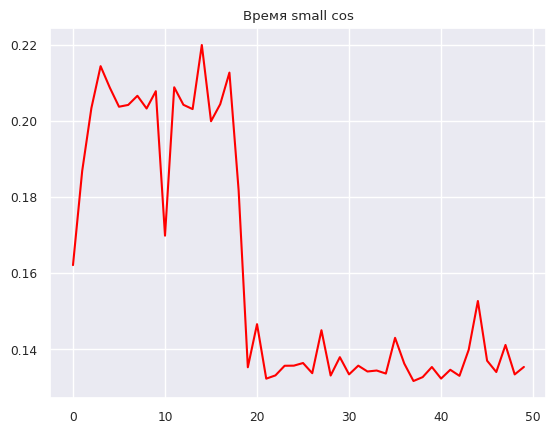

In [67]:
# Протестируем время извлечения ответов на 50 значениях + маленький датасет
sns.set_theme(palette ='pastel', font_scale=0.8)
t =  test(vectors, small, 'cos')
mean = sum(t)/len(t)
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="red").set_title("Время small cos");

In [68]:
# тест big cosine
%%time
results = search_(query, big, 'cos', w2v_rag_1536, top_k=1)
print(results)

                                             context_vec
47184  [-0.009879556, -0.0032072135, 0.009872427, 0.0...
CPU times: user 816 ms, sys: 660 ms, total: 1.48 s
Wall time: 1.4 s


Среднее время извлечения ответа: 1.065962314605713


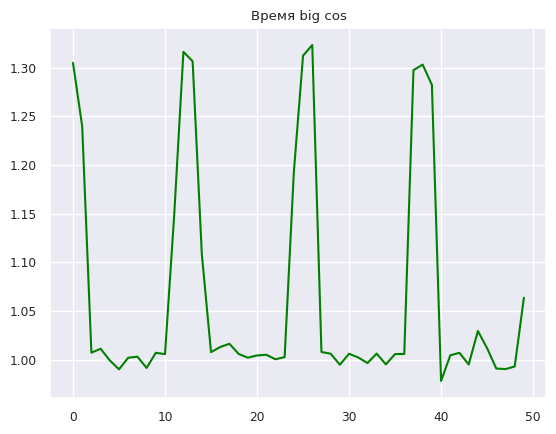

In [69]:
# Протестируем время извлечения ответов на 50 значениях + большой датасет

sns.set_theme(palette ='pastel', font_scale=0.8)
t =  test(vectors, big, 'cos')
mean = sum(t)/len(t)
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="green").set_title("Время big cos");

Поиск по эвклидову расстоянию

Среднее время извлечения ответа: 0.11980637073516846


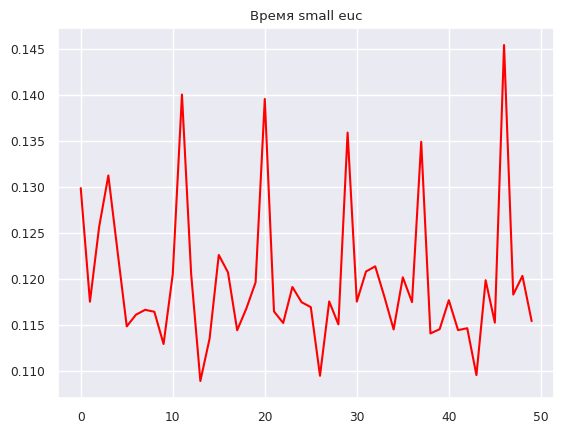

In [70]:
t =  test(vectors, small, 'euc')
mean = sum(t)/len(t)
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color = 'red').set_title("Время small euc");

Среднее время извлечения ответа: 1.4433760404586793


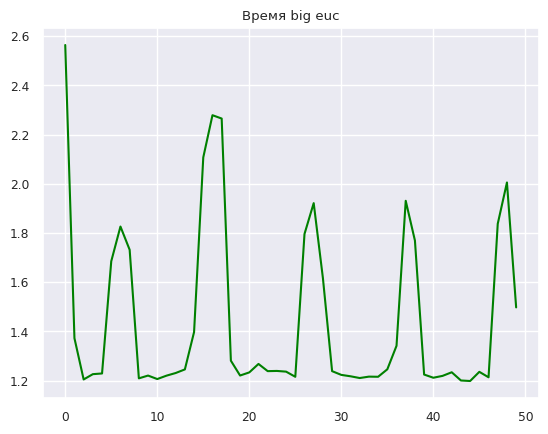

In [71]:
t =  test(vectors, big, 'euc')
mean = sum(t)/len(t)
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color = 'green').set_title("Время big euc");

Выводы: при увеличении датасета в 10 раз время поиска ответа возрастает примерно в 10 раз. Если на ~12 тыс данных извлечение происходит в среднем за 0.1 секунду, то на большом в 120 000 примерно за 1 - 1.4 секунды, в зависимости от метода подсчета близости.

## QDRANT

In [73]:
%pip install -U qdrant-client
clear_output()

In [74]:
from qdrant_client import models, QdrantClient
from qdrant_client.models import VectorParams, Distance
from sentence_transformers import SentenceTransformer,CrossEncoder

Загрузка готовых эмбеддингов w2vec в **qdrant**

### search_04 exact

In [75]:
qdrant_client = QdrantClient(":memory:")

In [76]:
# Создание коллекции
qdrant_client.recreate_collection(
    collection_name="w2vec_embeddings",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.COSINE,
    ),
)


True

In [80]:
small['id'] = small.index
df_w2v_1536['id'] = df_w2v_1536.index

In [81]:
# загрузка данных в базу
qdrant_client.upload_points(
    collection_name="w2vec_embeddings",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
            payload={"context":row[1]["context"]}
        )
        for row in df_w2v_1536.iterrows()
    ],
)


In [82]:
qdrant_client.count(
    collection_name='w2vec_embeddings',
    exact=True,
)

CountResult(count=11981)

In [83]:
df_w2v_1536.context[1110]

'manual on how to use an undergraduate thesis database one of the best things that we can appreciate about the learning environment today, is the fact that there are so many support systems in place, systems that were never there before. as a student, you have so much going on, so much working in your favor, that it would be reckless for you to fail any paper, just because you did not know what to do. a key element in the support systems today is the dissertation database. this collection of resources is one of the finest things that you will ever come across. you can imagine being able to work on your paper without any challenges, and mostly because you have a lot of support material that can assist you. for those who have never used such a database in their lives before, do not worry. the following are some key pointers that will help you make the best use of systems like this one, and be able to appreciate the results that come with it: - request support as early as possible - work 

In [84]:
query = df_w2v_1536.question[110]
test_query = get_phrase_embedding(query, w2v_rag_1536)
query, test_query

('why is the fairport public library moving to a new location?',
 array([-0.05058416,  0.08277725,  0.06186242, ..., -0.01929357,
         0.05533994,  0.03298458], dtype=float32))

In [85]:
# тест поиска
%%time
hits = qdrant_client.search(
    collection_name='w2vec_embeddings',
    query_vector=test_query,
    limit=1,

)

CPU times: user 59.9 ms, sys: 25.6 ms, total: 85.5 ms
Wall time: 86.8 ms


In [86]:
hits

[ScoredPoint(id=110, version=0, score=0.8523373603820801, payload={'context': 'fairport library closed for move the fairport public library will be moving to new digs as its current home undergoes renovations approved by voters. on monday the library at fairport village landing closed for its move to 30 perinton hills mall. the library hopes to reopen there on jan. 2. "we will have most of our collection there and a few computers for intenet access," said assistant library director tori reilly. "the staff will be available for reference questions and help." in may voters approved a $4.4 million renovation project for the library that includes new entrances, better lighting and new carpeting, and changes that will allow roomier space for programs. the renovations are expected to take eight to 10 months to complete, reilly said. library staff is working on how best to handle programs such as children story hours and book discussions while in the temporary space, she said. once in the new

In [89]:
def test_q(vectors):
    plt = []
    for test_query in vectors:
        start = time.time()
        qdrant_client.search(
        collection_name='w2vec_embeddings',
        query_vector=test_query,
        limit=1,)
        end = time.time()
        res = end - start
        plt.append(res)
    return plt

Среднее время извлечения ответа: 0.0733864164352417


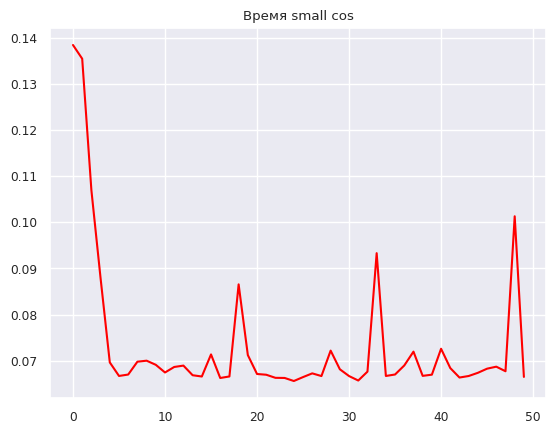

In [90]:
# Протестируем время извлечения ответов на 50 значениях
sns.set_theme(palette ='pastel', font_scale=0.8)
t =  test_q(vectors)
mean = sum(t)/len(t)
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="red").set_title("Время small cos");

Время извлечения ответа из БД 0.07 секунды на ~12 тыc строках, против 0.1 при работе с датафремом пандаc. Результат значительно лучше!!!
При том, что здесь используется exact поиск брутфорсом.

### search_05 qdrant когда в БД только векторы и HnswConfigDiff

Используем ранее подготовленный датасет small, в нем только векторы длиной 1536

In [91]:
small.shape

(11981, 2)

In [99]:
qdrant_small = QdrantClient(":memory:")

In [100]:
# Создание коллекции
qdrant_small.recreate_collection(
    collection_name="small",
    vectors_config=models.VectorParams(
        size=1536,  # Vector size is defined by used model
        distance=models.Distance.COSINE,
    ),
)

True

In [101]:
qdrant_small.upload_points(
    collection_name="small",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
        )
        for row in small.iterrows()
    ],
)

In [102]:
qdrant_small.count(
    collection_name="small",
    exact=True,
)

CountResult(count=11981)

In [105]:
def test_q(vectors):
    plt = []
    for test_query in vectors:
        start = time.time()
        qdrant_small.search(
        collection_name='small',
        query_vector=test_query,
        limit=1,)
        end = time.time()
        res = end - start
        plt.append(res)
    return plt

Среднее время извлечения ответа: 0.05421116352081299


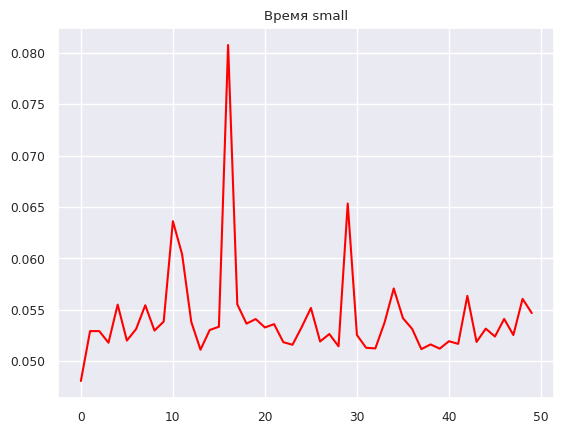

In [117]:
# Протестируем время извлечения ответов на 50 значениях
sns.set_theme(palette ='pastel', font_scale=0.8)
t =  test_q(vectors)
mean = sum(t)/len(t)
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="red").set_title("Время small");

Создаем новую коллекцию с использованием HnswConfigDiff

In [108]:
qdrant_small_hnsw = QdrantClient(":memory:")

In [122]:
qdrant_small_hnsw.recreate_collection(
    collection_name="small",
    vectors_config=models.VectorParams(
        size=1536,
        distance=models.Distance.COSINE,
        hnsw_config=models.HnswConfigDiff(
        m=16,
        ef_construct=80,
)
    ),
        hnsw_config=models.HnswConfigDiff(
        ef_construct=80,
    )
)

True

In [123]:
qdrant_small_hnsw.upload_points(
    collection_name="small",
    points=[
        models.PointStruct(
            id=row[1]["id"],
            vector=(row[1]["context_vec"]),
        )
        for row in small.iterrows()
    ],
)

In [111]:
qdrant_small_hnsw.count(
    collection_name="small",
    exact=True,
)

CountResult(count=11981)

In [124]:
def test_q(vectors):
    plt = []
    for test_query in vectors:
        start = time.time()
        qdrant_small_hnsw.search(
        collection_name='small',
        query_vector=test_query,
        limit=1,)
        end = time.time()
        res = end - start
        plt.append(res)
    return plt

Среднее время извлечения ответа: 0.053671135902404785


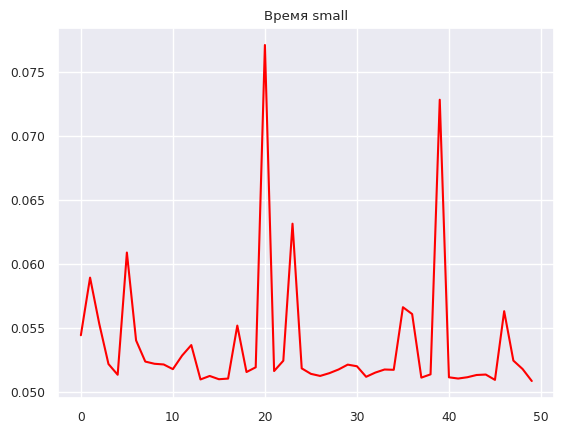

In [128]:
t =  test_q(vectors)
mean = sum(t)/len(t)
print('Среднее время извлечения ответа:', mean)
sns.lineplot(t, color="red").set_title("Время small");

## Выводы:

1. По качеству использования векторизации с помощью Word2Vec не устраивает.
2. По скорости работы с Word2Vec из датафрейма показывает,ч то чем больше данных, тем значительно медленнее идет извлечение. 12 тысяч 0.1 секунды, 120 тысяч - 1-1.3 секунды в среднем.
3. Скорость извлечения векторов при использовании Qdrant значительно выше  - 0.07 секунды, если в БД лежат и контексты, вопросы, ответы и векторы; 0.05 если в БД только векторы.
4. Далее планируется развернуть Qdrant в докере и протестировать на большом и маленьком объеме данных.